In [57]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from multiprocessing import cpu_count
from torch.nn import functional as F

In [88]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

In [63]:
df = pd.read_csv(r'C:\Users\neele\OneDrive\Documents\Dataset\series\training\x_train.csv')

In [64]:
df_test = pd.read_csv(r'C:\Users\neele\OneDrive\Documents\Dataset\series\series\X_test.csv')

In [65]:
df_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,0.91208,-0.38193,-0.050618,0.14028,-0.060205,0.071286,-0.18787,0.29492,2.8027,-9.6816
1,0_1,0,1,0.91220,-0.38165,-0.050573,0.14028,-0.033486,0.060210,-0.18206,0.14944,2.5408,-9.8521
2,0_2,0,2,0.91228,-0.38143,-0.050586,0.14032,-0.029686,0.029476,-0.18441,-0.49741,2.5853,-9.3835
3,0_3,0,3,0.91237,-0.38121,-0.050588,0.14035,-0.024217,0.037788,-0.18783,-0.32376,2.9966,-8.7415
4,0_4,0,4,0.91247,-0.38096,-0.050546,0.14042,-0.038047,0.083405,-0.20170,-0.70103,2.6498,-8.8432


In [66]:
dfy = pd.read_csv(r'C:\Users\neele\OneDrive\Documents\Dataset\series\training\y_train.csv')

In [67]:
df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [68]:
dfy.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [69]:
enc = LabelEncoder()
y_enc = enc.fit_transform(dfy['surface'])
y_enc

array([2, 1, 1, ..., 2, 7, 5])

In [70]:
dfy['encoding'] = y_enc

In [71]:
dfy[dfy['series_id'] == 1]['encoding'].values[0]

1

In [72]:
df_grouped = df.groupby('series_id')

data = []

columns = ['orientation_X', 'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z']

for i, item in enumerate(df_grouped):
    
    group_data = []
    # print(item[1])

    for row in item[1].iterrows():

        row_data = []
        
        for column in columns:
            
            row_data.append(row[1][column])

        group_data.append(row_data)

    data.append((group_data,y_enc[i])) 
    

In [73]:
data_df = pd.DataFrame(data, columns=['X','y'])

In [74]:
X = list(data_df['X'])

In [75]:
y = list(data_df['y'])

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [77]:
len(X_train)

3429

In [78]:
x_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [82]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_test, y_test)

trn_dl = DataLoader(train_ds, 128, shuffle=True)
val_dl = DataLoader(valid_ds, 128, shuffle=False)

In [97]:
class LSTMModule(nn.Module):

    def __init__(self):
        super(LSTMModule, self).__init__()

        self.input_layer_size = 10
        self.hidden_layer_size = 256
        self.output_layer_size = 9

        self.lstm = nn.LSTM(self.input_layer_size, self.hidden_layer_size, 3, batch_first=True)
        self.fc = nn.Linear(self.hidden_layer_size, self.output_layer_size)

    def forward(self, input_seq):

        self.hidden_cell = (torch.zeros(3,input_seq.size(0),self.hidden_layer_size).to(device), torch.zeros(3,input_seq.size(0),self.hidden_layer_size).to(device))

        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        predictions = self.fc(lstm_out[:, -1, :])
        return predictions

In [42]:
model = LSTMModule().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0005)

In [89]:
epochs = 10

running_loss_history = []
epoch_list = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

model.train()

for i in range(epochs):

    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    running_loss = 0.0

    for seq, labels in zip(x_train, y_train):

        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(3, 1, 256).to(device), torch.zeros(3, 1, 256).to(device))
      
        y_pred = model(seq.view(-1,128,10))

        single_loss = criterion(y_pred.view(1,-1), labels.view(1))
        single_loss.backward()
        optimizer.step()

        preds = torch.round(y_pred).argmax().to(int).squeeze(0)
        running_corrects += torch.sum(preds == labels)

        running_loss += single_loss.item()


    else:
        with torch.no_grad():
            for val_inputs, val_labels in zip(x_test, y_test):

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs.view(1,-1), val_labels.view(1))
                
                val_preds = torch.round(val_outputs).argmax().to(int).squeeze(0)

                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels)

        
    epoch_loss = running_loss/len(x_train)
    epoch_acc = running_corrects.float()/ len(x_train)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_acc = val_running_corrects.float()/ len(x_test)
    val_epoch_loss = val_running_loss/ len(x_test)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    epoch_list.append(i + 1)

    print("Epoch : ",i + 1)
    print('training loss: {:.4f}, acc {:.4f} '.format(running_loss/len(x_train), epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))
    print('_'*20)
    

RuntimeError: Input and hidden tensors are not at the same device, found input tensor at cpu and hidden tensor at cuda:0

In [80]:
class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]

In [98]:
input_dim = 10    
hidden_dim = 256
layer_dim = 3
output_dim = 9
seq_dim = 128

lr = 0.0005
n_epochs = 1000
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0

#model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = LSTMModule()

model = model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        
        model.train()

        model.hidden_cell = (torch.zeros(3, 128, 256).to(device), torch.zeros(3, 128, 256).to(device))

        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
        
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in val_dl:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training


C:\Users\neele\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 best model saved with accuracy: 27.82%
Epoch 3 best model saved with accuracy: 29.92%
Epoch 4 best model saved with accuracy: 32.55%
Epoch:   5. Loss: 1.7710. Acc.: 33.33%
Epoch 5 best model saved with accuracy: 33.33%
Epoch 7 best model saved with accuracy: 37.01%
Epoch 9 best model saved with accuracy: 38.32%


KeyboardInterrupt: 

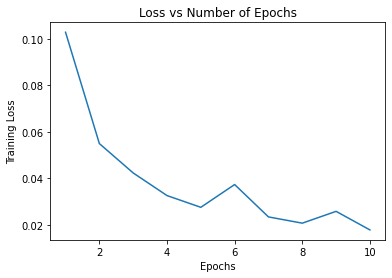

In [60]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss vs Number of Epochs")
plt.show()

Text(69.0, 0.5, 'Predicted Values')

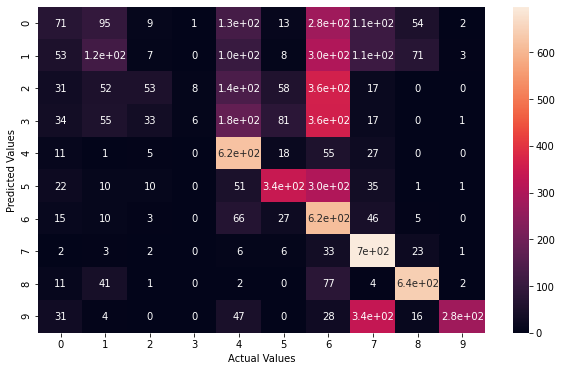

In [73]:
predictions=[]

with torch.no_grad():
        model.eval()

        for inputs, labels in zip(x_test, y_test):

                output = model(inputs)          
                predictions.append(output.argmax().to(int).to('cpu').item())
        
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.to('cpu').numpy(),predictions)
cm

plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')